# Imports and Data Loading

In this step, we import the necessary libraries for data preprocessing, model training, evaluation, and visualization. We also suppress warnings for cleaner output.

- Libraries like `pandas`, `sklearn`, `numpy` and `tensorflow` are used for various tasks.
- The dataset is loaded from a CSV file, ready for exploratory data analysis.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data
dataset = pd.read_csv('Data Project Data.csv')

# Exploratory Data Analysis (EDA)

## Pitch Type Distribution
- Visualized the distribution of `pitch_type` to understand the dataset's balance.
- Observed the frequency of each pitch type.

## Correlation Matrix for Features
- Calculated the correlation matrix for numerical features.
- Plotted a heatmap to visualize relationships between features.
- Key takeaway: Identify features with high correlation, which may show which features are best used to predict the pitches.

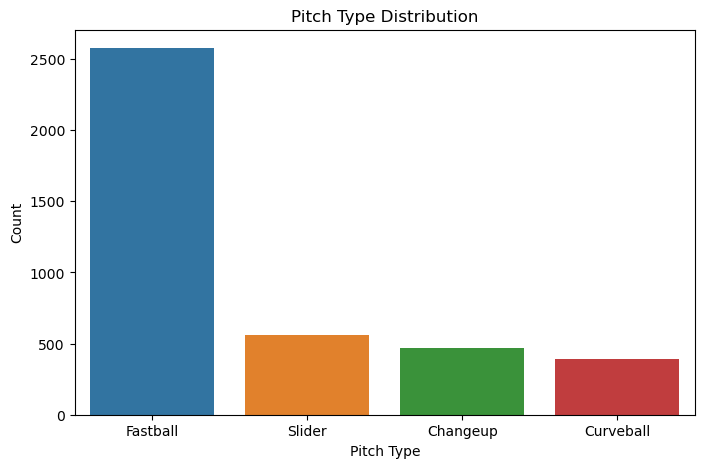

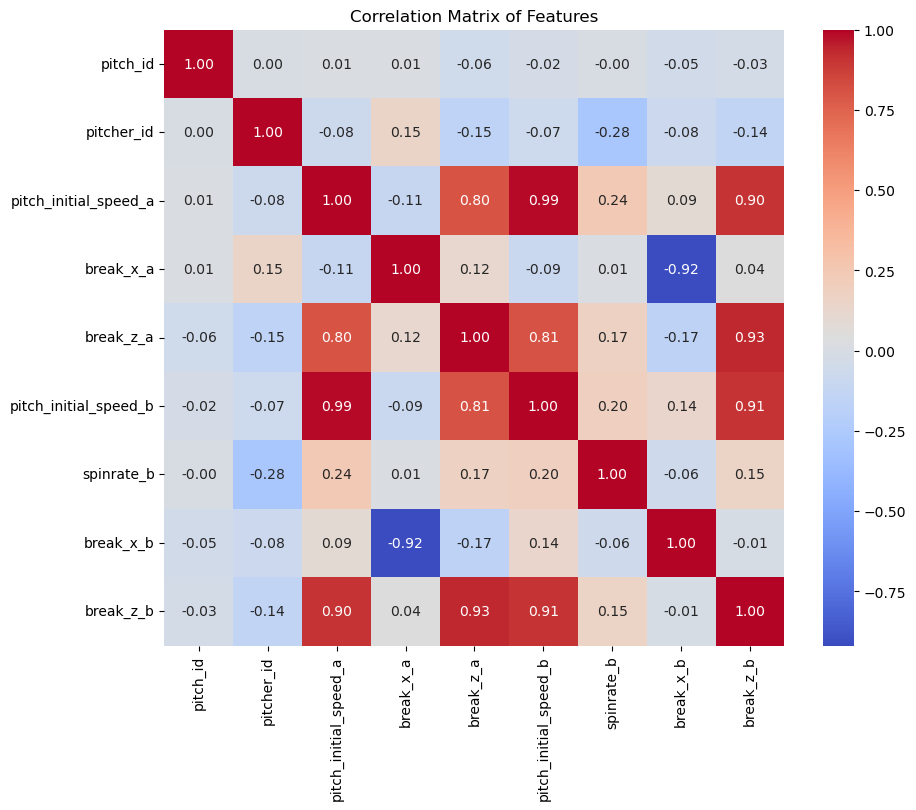

(pitch_type
 Fastball     2577
 Slider        562
 Changeup      469
 Curveball     392
 Name: count, dtype: int64,
                            pitch_id    pitcher_id  pitch_initial_speed_a  \
 pitch_id               1.000000e+00  1.069795e-15               0.014994   
 pitcher_id             1.069795e-15  1.000000e+00              -0.077287   
 pitch_initial_speed_a  1.499359e-02 -7.728673e-02               1.000000   
 break_x_a              1.091224e-02  1.464920e-01              -0.114191   
 break_z_a             -5.537185e-02 -1.542443e-01               0.799957   
 pitch_initial_speed_b -2.159165e-02 -6.874887e-02               0.987586   
 spinrate_b            -1.885201e-03 -2.777361e-01               0.243421   
 break_x_b             -4.847081e-02 -8.448277e-02               0.089570   
 break_z_b             -2.784496e-02 -1.445003e-01               0.904050   
 
                        break_x_a  break_z_a  pitch_initial_speed_b  \
 pitch_id                0.010912  -0.055

In [3]:
# Exploratory Data Analysis
pitch_type_counts = dataset['pitch_type'].value_counts()

# Plot pitch type distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=pitch_type_counts.index, y=pitch_type_counts.values)
plt.title("Pitch Type Distribution")
plt.xlabel("Pitch Type")
plt.ylabel("Count")
plt.show()

# Correlation matrix for numerical columns
numeric_columns = dataset.select_dtypes(include=["float64", "int64"])
correlation_matrix = numeric_columns.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()

pitch_type_counts, correlation_matrix

# Modeling

To classify the missing pitches, I used 5 different multiclassification models to determine the pitches based on the features determined from the EDA. Here we are gonna use both System A and System B's measurements for out models. We are training a K Nearest Neighbors, Random Forest, Logistic Regression, Support Vector Machine, and a neural network.

In [4]:
# Step 1: Preprocessing
features = [
    "pitch_initial_speed_a", "break_x_a", "break_z_a",
    "pitch_initial_speed_b", "spinrate_b", "break_x_b", "break_z_b"
]
data_with_pitch_types = dataset.dropna(subset=["pitch_type"])
data_without_pitch_types = dataset[dataset["pitch_type"].isnull()]

# Impute missing values
imputer = SimpleImputer(strategy="mean")
data_with_pitch_types[features] = imputer.fit_transform(data_with_pitch_types[features])
data_without_pitch_types[features] = imputer.transform(data_without_pitch_types[features])

# Map pitch types to numerical values
pitch_type_mapping = {ptype: idx for idx, ptype in enumerate(data_with_pitch_types["pitch_type"].unique())}
reverse_mapping = {idx: ptype for ptype, idx in pitch_type_mapping.items()}
data_with_pitch_types["pitch_type"] = data_with_pitch_types["pitch_type"].map(pitch_type_mapping)

# Standardize features
scaler = StandardScaler()
data_with_pitch_types[features] = scaler.fit_transform(data_with_pitch_types[features])
data_without_pitch_types[features] = scaler.transform(data_without_pitch_types[features])

# Split data into train, validation, and test sets
X = data_with_pitch_types[features].values
y = data_with_pitch_types["pitch_type"].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Train and evaluate multiple methods
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced"),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "SVM": SVC(kernel="linear", probability=True, class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    results[name] = {
        "model": model,
        "accuracy": accuracy
    }
    print(f"\n{name} Validation Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_val_pred, target_names=reverse_mapping.values()))


Random Forest Validation Accuracy: 0.9767
              precision    recall  f1-score   support

    Fastball       0.99      0.99      0.99       386
      Slider       0.96      0.96      0.96        85
   Curveball       0.96      0.91      0.94        58
    Changeup       0.92      0.94      0.93        71

    accuracy                           0.98       600
   macro avg       0.96      0.95      0.96       600
weighted avg       0.98      0.98      0.98       600


Logistic Regression Validation Accuracy: 0.7933
              precision    recall  f1-score   support

    Fastball       0.97      0.88      0.93       386
      Slider       0.57      0.64      0.60        85
   Curveball       0.67      0.76      0.71        58
    Changeup       0.41      0.52      0.46        71

    accuracy                           0.79       600
   macro avg       0.66      0.70      0.67       600
weighted avg       0.82      0.79      0.80       600


SVM Validation Accuracy: 0.8067
     

# Model Performance Metrics

## Random Forest Classifier
- **Validation Accuracy**: `97.67%`
- Achieved high precision and recall across all pitch types.
- Notable performance in identifying less frequent pitches like `Changeup` and `Curveball`.

## Logistic Regression
- **Validation Accuracy**: `79.33%`
- Struggled with certain pitch types, especially `Changeup`.
- Precision and recall indicate less effective predictions compared to Random Forest.

## SVM
- **Validation Accuracy**: `80.67%`
- Similar performance to Logistic Regression but better at `Curveball` predictions.

## KNN
- **Validation Accuracy**: `96.67%`
- Close performance to Random Forest, with high accuracy in most pitch types.


# TensorFlow Model

## Preprocessing
- One-hot encoding applied to pitch labels to prepare them for TensorFlow training.

## Model Architecture
- Two dense layers with ReLU activation.
- Final layer uses a softmax activation to predict one of the pitch types.

## Training Results
- Validation Accuracy: Printed after training for each epoch.
- Observed overfitting in later epochs due to the model complexity

In [5]:
#one hot encode the pitching data (pitch labels)
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.reshape(-1, 1))

X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train_encoded, dtype=tf.float32)
X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tf = tf.convert_to_tensor(y_val_encoded, dtype=tf.float32)

# Define TensorFlow Model
input_size = len(features)
num_classes = len(pitch_type_mapping)

tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_size,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = tf_model.fit(
    X_train_tf, y_train_tf,
    validation_data=(X_val_tf, y_val_tf),
    epochs=20,
    batch_size=32,
    verbose=1
)

val_loss, val_accuracy = tf_model.evaluate(X_val_tf, y_val_tf, verbose=1)
print(f"\nTensorFlow Model Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/20


2024-11-28 19:32:17.628331: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


88/88 [==============================] - 1s 2ms/step - loss: 0.9442 - accuracy: 0.6668 - val_loss: 0.6036 - val_accuracy: 0.7517
Epoch 2/20
88/88 [==============================] - 0s 779us/step - loss: 0.5067 - accuracy: 0.7857 - val_loss: 0.4369 - val_accuracy: 0.8283
Epoch 3/20
88/88 [==============================] - 0s 778us/step - loss: 0.3926 - accuracy: 0.8639 - val_loss: 0.3466 - val_accuracy: 0.8983
Epoch 4/20
88/88 [==============================] - 0s 894us/step - loss: 0.3176 - accuracy: 0.9050 - val_loss: 0.2845 - val_accuracy: 0.9450
Epoch 5/20
88/88 [==============================] - 0s 755us/step - loss: 0.2689 - accuracy: 0.9225 - val_loss: 0.2425 - val_accuracy: 0.9517
Epoch 6/20
88/88 [==============================] - 0s 773us/step - loss: 0.2342 - accuracy: 0.9364 - val_loss: 0.2119 - val_accuracy: 0.9450
Epoch 7/20
88/88 [==============================] - 0s 741us/step - loss: 0.2108 - accuracy: 0.9386 - val_loss: 0.1918 - val_accuracy: 0.9400
Epoch 8/20
88/88 [=

## Tensorflow
- **Validation Accuracy**: `97.00%`
- Close performance to Random Forest and KNN, with high accuracy in most pitch types.

# Validation Accuracies Comparison

- A bar chart comparing the validation accuracies of all models (Random Forest, Logistic Regression, SVM, KNN, and TensorFlow).
- Random Forest achieves the highest accuracy, followed closely by KNN and TensorFlow.
- Logistic Regression and SVM lag behind, highlighting the importance of choosing more complex models for this dataset.


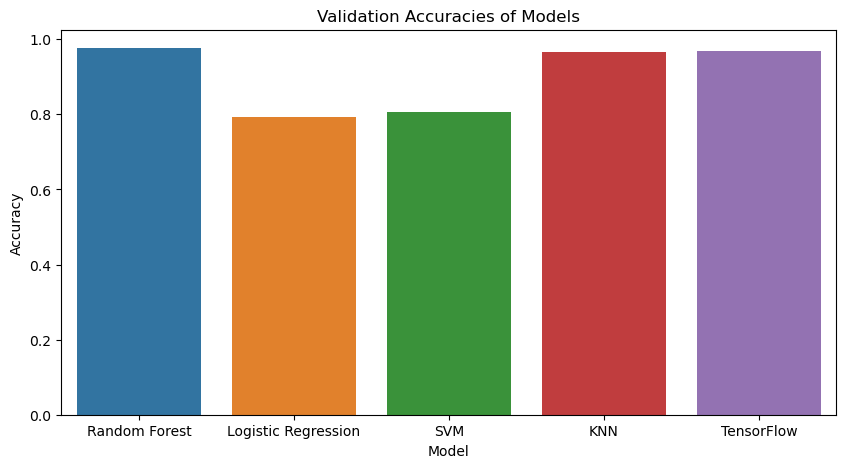

In [6]:
all_accuracies = {name: results[name]["accuracy"] for name in results}
all_accuracies["TensorFlow"] = val_accuracy

# Plot accuracies
plt.figure(figsize=(10, 5))
sns.barplot(x=list(all_accuracies.keys()), y=list(all_accuracies.values()))
plt.title("Validation Accuracies of Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()


Confusion Matrix for Random Forest:


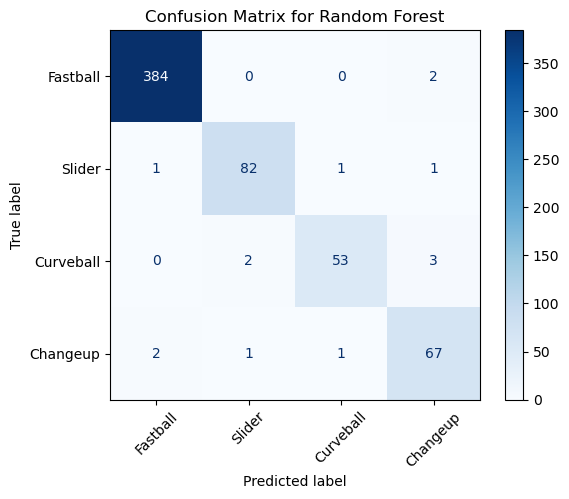


Confusion Matrix for Logistic Regression:


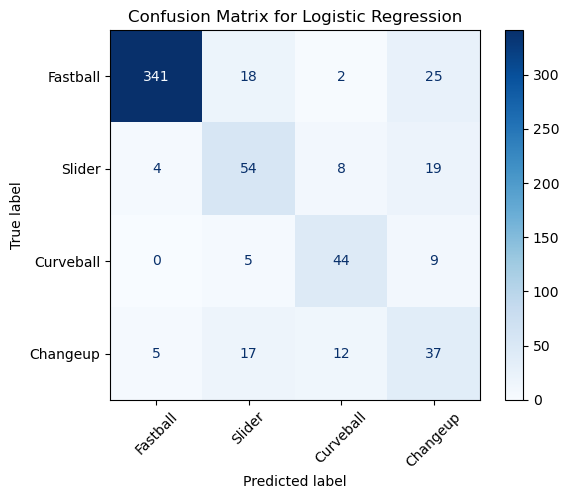


Confusion Matrix for SVM:


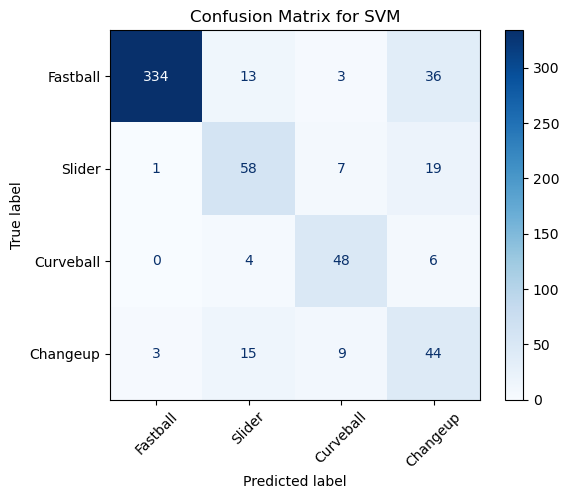


Confusion Matrix for KNN:


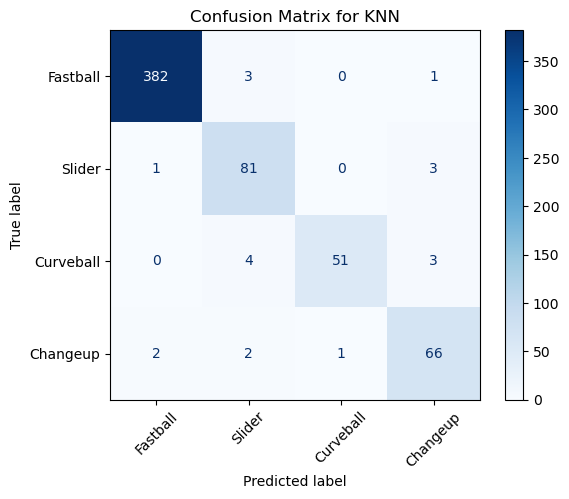

19/19 [==============================] - 0s 439us/step

Confusion Matrix for TensorFlow Model:


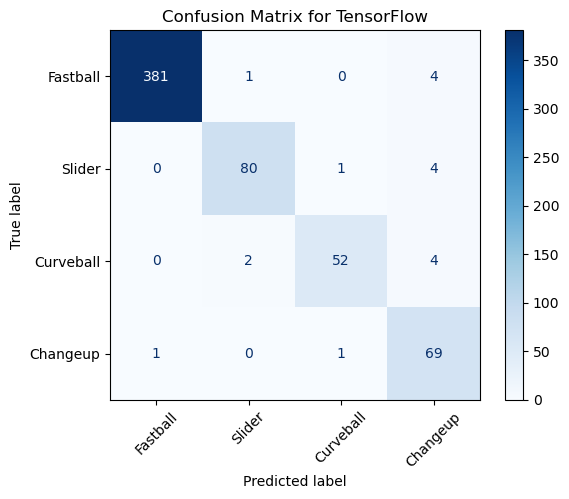

In [ ]:

def plot_confusion_matrix(y_true, y_pred, model_name, labels):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

for name, model in models.items():
    y_val_pred = model.predict(X_val)
    print(f"\nConfusion Matrix for {name}:")
    plot_confusion_matrix(y_val, y_val_pred, model_name=name, labels=list(reverse_mapping.values()))

tf_pred_classes = tf.argmax(tf_model.predict(X_val_tf), axis=1).numpy()
print("\nConfusion Matrix for TensorFlow Model:")
plot_confusion_matrix(y_val, tf_pred_classes, model_name="TensorFlow", labels=list(reverse_mapping.values()))

# Confusion Matrices
- Confusion matrices provide a detailed breakdown of model predictions for each pitch type.

## Random Forest
- Clear dominance in correctly classifying all pitch types.
- Minimal misclassification for `Curveball` and `Changeup`.
- able to classify the most true labels in predictions

## KNN
- High accuracy but slightly worse performance compared to Random Forest for rare classes.

## TensorFlow
- Similar to Random Forest, performs well but struggles with certain misclassifications.
- Provides insights into where the model can be improved.


# Hyperparameter Tuning

## KNN Grid Search
- Tuned parameters include `n_neighbors`, `weights`, and `metric`.
- Best parameters achieved:
  - `n_neighbors`: 5
  - `weights`: Distance
  - `metric`: Minkowski

## Random Forest Grid Search
- Tuned parameters include `n_estimators`, `max_depth`, and others.
- Best parameters achieved:
  - `n_estimators`: 200
  - `max_depth`: 20
  - `min_samples_split`: 2

## TensorFlow Tuning
- Tuned hyperparameters like `learning_rate`, `batch_size`, and `epochs`.
- Achieved the best validation accuracy with:
  - `units1`: 64, `units2`: 32
  - `learning_rate`: 0.001
  - `batch_size`: 32
  - `epochs`: 20


In [ ]:
# Tuning using Grid Search
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid,
    cv=3, scoring='accuracy', n_jobs=-1, verbose=2
)

knn_grid_search.fit(X_train, y_train)
print("Best Parameters for KNN:", knn_grid_search.best_params_)
print("Best Cross-Validation Accuracy for KNN:", knn_grid_search.best_score_)

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=3, scoring='accuracy', n_jobs=-1, verbose=2
)

rf_grid_search.fit(X_train, y_train)
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Best Cross-Validation Accuracy for Random Forest:", rf_grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weig

In [ ]:
# Define a function to build and train a TensorFlow model with varying hyperparameters
def train_tf_model(units1, units2, learning_rate, epochs, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units1, activation='relu', input_shape=(len(features),)),
        tf.keras.layers.Dense(units2, activation='relu'),
        tf.keras.layers.Dense(len(pitch_type_mapping), activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        X_train_tf, y_train_tf,
        validation_data=(X_val_tf, y_val_tf),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    val_loss, val_accuracy = model.evaluate(X_val_tf, y_val_tf, verbose=0)
    print(f"Model with units1={units1}, units2={units2}, lr={learning_rate}, batch_size={batch_size}: "
          f"Validation Accuracy={val_accuracy:.4f}")
    return model, val_accuracy

tf_hyperparams = [
    {'units1': 64, 'units2': 32, 'learning_rate': 0.001, 'epochs': 20, 'batch_size': 32},
    {'units1': 128, 'units2': 64, 'learning_rate': 0.001, 'epochs': 20, 'batch_size': 32},
    {'units1': 64, 'units2': 32, 'learning_rate': 0.01, 'epochs': 30, 'batch_size': 16},
    
]

best_tf_model = None
best_tf_accuracy = 0

for params in tf_hyperparams:
    model, accuracy = train_tf_model(**params)
    if accuracy > best_tf_accuracy:
        best_tf_model = model
        best_tf_accuracy = accuracy

print(f"\nBest TensorFlow Model Validation Accuracy: {best_tf_accuracy:.4f}")


Model with units1=64, units2=32, lr=0.001, batch_size=32: Validation Accuracy=0.9667
Model with units1=128, units2=64, lr=0.001, batch_size=32: Validation Accuracy=0.9650
Model with units1=64, units2=32, lr=0.01, batch_size=16: Validation Accuracy=0.9617

Best TensorFlow Model Validation Accuracy: 0.9667


# F1 Score and Confusion Matrix After Hyperparameter Tuning

## Overview
After tuning the hyperparameters for the **KNN**, **Random Forest**, and **TensorFlow** models, the results are evaluated based on F1-scores and confusion matrices. These metrics provide insights into the effectiveness of each model at predicting pitch types, especially for imbalanced data.



Confusion Matrix for Best KNN Model:


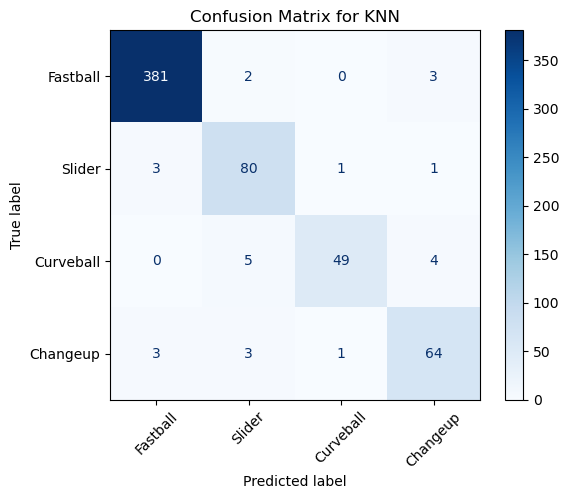


Confusion Matrix for Best Random Forest Model:


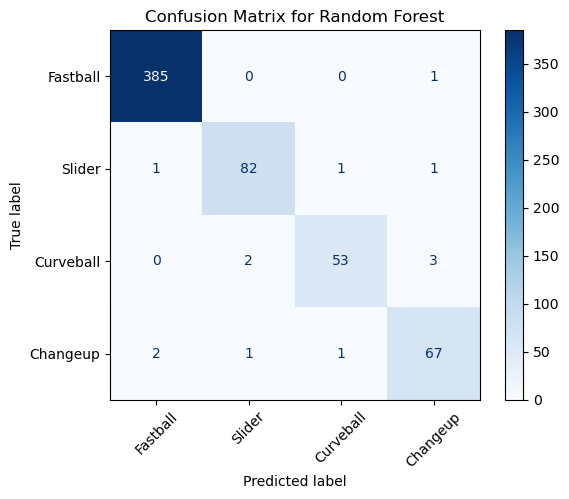

19/19 [==============================] - 0s 477us/step

Confusion Matrix for Best TensorFlow Model:


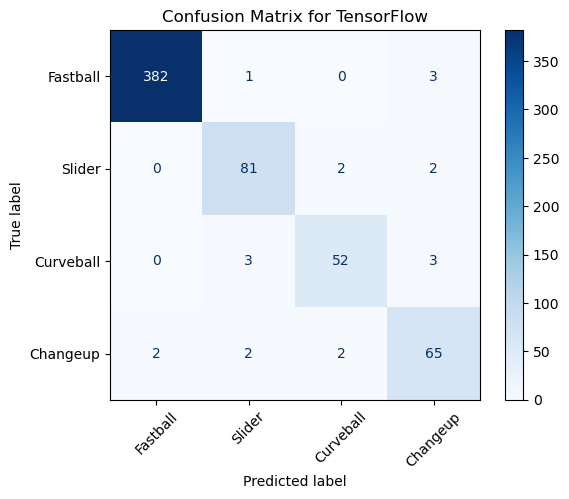

In [ ]:
knn_best_model = knn_grid_search.best_estimator_
knn_y_val_pred = knn_best_model.predict(X_val)
print("\nConfusion Matrix for Best KNN Model:")
plot_confusion_matrix(y_val, knn_y_val_pred, model_name="KNN", labels=list(reverse_mapping.values()))

rf_best_model = rf_grid_search.best_estimator_
rf_y_val_pred = rf_best_model.predict(X_val)
print("\nConfusion Matrix for Best Random Forest Model:")
plot_confusion_matrix(y_val, rf_y_val_pred, model_name="Random Forest", labels=list(reverse_mapping.values()))

tf_y_val_pred = tf.argmax(best_tf_model.predict(X_val_tf), axis=1).numpy()
print("\nConfusion Matrix for Best TensorFlow Model:")
plot_confusion_matrix(y_val, tf_y_val_pred, model_name="TensorFlow", labels=list(reverse_mapping.values()))

## Confusion Matrix Analysis
Confusion matrices provide a detailed breakdown of the true positives, false positives, false negatives, and true negatives for each pitch type. They are visualized for each tuned model.

### Random Forest
- **Strengths**:
  - Excellent accuracy for `Fastball`, with minimal misclassifications.
  - Performs well on minority classes like `Curveball` and `Changeup`.
- **Weaknesses**:
  - Slight confusion between `Slider` and `Curveball` in rare cases.

### KNN
- **Strengths**:
  - High accuracy for `Fastball` and `Slider`.
  - Performs nearly as well as Random Forest on `Curveball`.
- **Weaknesses**:
  - Minor misclassifications for `Changeup`, showing room for improvement.

### TensorFlow
- **Strengths**:
  - Comparable performance to Random Forest on majority classes (`Fastball`, `Slider`).
- **Weaknesses**:
  - Higher misclassification rates for `Changeup` and `Curveball`.


In [ ]:
# Calculate F1-Scores for each model
knn_f1 = f1_score(y_val, knn_y_val_pred, average='weighted')
rf_f1 = f1_score(y_val, rf_y_val_pred, average='weighted')
tf_f1 = f1_score(y_val, tf_y_val_pred, average='weighted')

print(f"KNN F1-Score: {knn_f1:.4f}")
print(f"Random Forest F1-Score: {rf_f1:.4f}")
print(f"TensorFlow F1-Score: {tf_f1:.4f}")

if rf_f1 >= max(knn_f1, tf_f1):
    best_model_name = "Random Forest"
    best_model = rf_best_model
elif knn_f1 >= max(rf_f1, tf_f1):
    best_model_name = "KNN"
    best_model = knn_best_model
else:
    best_model_name = "TensorFlow"
    best_model = best_tf_model

print(f"\nBest Model Based on F1-Score: {best_model_name}")


KNN F1-Score: 0.9565
Random Forest F1-Score: 0.9782
TensorFlow F1-Score: 0.9668

Best Model Based on F1-Score: Random Forest


## F1-Score Analysis
- The **weighted F1-score** captures both precision and recall while accounting for class imbalance.
- Models with high F1-scores indicate strong prediction capabilities for all pitch types.

### Results:
- **Random Forest**: F1-Score = `97.8%`
  - Best-performing model after tuning.
  - Balanced precision and recall across all pitch types.
- **KNN**: F1-Score = `95.6%`
  - High performance but slightly lower than Random Forest.
  - Minor struggles with less frequent pitch types.
- **TensorFlow**: F1-Score = `96.6%`
  - Comparable to Random Forest but slightly lower precision on minority classes.

In [14]:
# Predict missing labels with the best model
X_missing = data_without_pitch_types[features]

if best_model_name == "TensorFlow":
    X_missing_tf = tf.convert_to_tensor(X_missing, dtype=tf.float32)
    predicted_probs = best_model.predict(X_missing_tf)
    predicted_classes = tf.argmax(predicted_probs, axis=1).numpy()
else:
    predicted_classes = best_model.predict(X_missing)

reverse_mapping = {idx: pitch for pitch, idx in pitch_type_mapping.items()}

# Map numeric predictions to pitch type names
predicted_labels = [reverse_mapping[pred] for pred in predicted_classes]

# Add the predictions to the missing rows
data_without_pitch_types["pitch_type"] = predicted_labels


# Save the updated dataset to a new CSV file
output_path = 'pitch_predictions.csv'
data_without_pitch_types.to_csv(output_path, index=False)

print(f"Updated dataset with predicted pitch_type labels saved to: {output_path}")

Updated dataset with predicted pitch_type labels saved to: pitch_predictions.csv


In [13]:
reverse_mapping = {idx: pitch for pitch, idx in pitch_type_mapping.items()}
data_without_pitch_types["pitch_type"] = [reverse_mapping[pred] for pred in predicted_classes]

# Merge the updated rows back into the original dataset
updated_dataset = dataset.copy()
updated_dataset.update(data_without_pitch_types)
output_path = 'final.csv'
updated_dataset.to_csv(output_path, index=False)

print(f"Updated overall dataset with predicted pitch_type labels saved to: {output_path}")

Updated overall dataset with predicted pitch_type labels saved to: final.csv


## Conclusion
- **Random Forest** emerges as the best model after hyperparameter tuning.
  - Achieved the highest F1-score (`97.8%`).
  - Minimal misclassification in confusion matrix.
- **KNN** and **TensorFlow** follow closely but struggle with rare classes.
- The confusion matrices and F1-scores highlight the robustness of Random Forest for this dataset.
- created two csv files
    - `final.csv` contains all 5000 pitches including the predictions for the 1000 pitches that were not classified
    - `pitch_predictions` contains the classification of only the 1000 pitches that were not classified.